In [1]:
import ROOT
import seaborn as sns
import pandas as pd
import numpy as np

Welcome to JupyROOT 6.30/08


In [34]:
digi_file_name = "/lustre/land/ilihtar/neuland/sim_August24/digi1n_phasespace_25MeV_thresh0.root"
simu_file_name = "/lustre/land/ilihtar/neuland/sim_August24/sim1n_phasespace_25MeV.root"
digi_file = ROOT.TFile(digi_file_name)
simu_file = ROOT.TFile(simu_file_name)
hit_branches = ["NeulandHits.fT", "NeulandHits.fPaddle"]
point_branches = ["NeulandPoints.fTime", "NeulandPoints.fDetectorID"]
hit_data_arrays = ROOT.RDataFrame("evt", digi_file).AsNumpy(hit_branches)
point_data_arrays = ROOT.RDataFrame("evt", simu_file).AsNumpy(point_branches)

In [28]:
event_size = len(data[branches[0]])
hit_times = np.zeros(event_size, dtype = 'float32')
hit_plane_ids = np.zeros(event_size, dtype = 'int') # starts from 0
hit_times[:] = np.nan
hit_plane_ids[:] = -1

event_index = 0
for fTs, paddleNums in zip(hit_data_arrays[hit_branches[0]], hit_data_arrays[hit_branches[1]]):
    if len(fTs) != 0:
        fT_min, paddle_num = min(zip(fTs, paddleNums), key = lambda x: x[0])
        hit_times[event_index] = fT_min
        hit_plane_ids[event_index] = (paddle_num - 1) // 50
    event_index += 1

Text(0.5, 1.0, 'neulandHits')

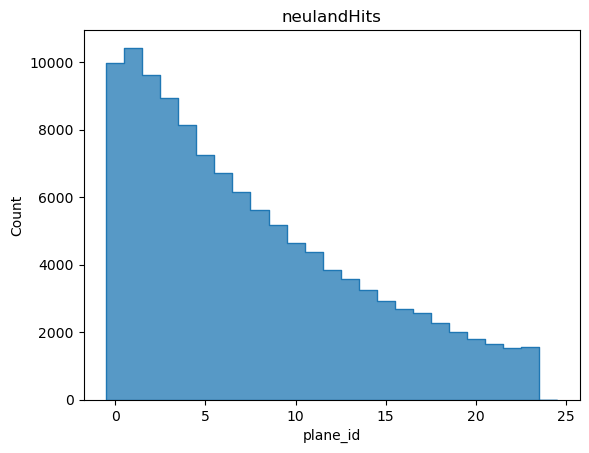

In [40]:
data_frame_hits = pd.DataFrame({"plane_id": hit_plane_ids, "times": hit_times}).dropna()
graph = sns.histplot(data = data_frame_hits, x = "plane_id", binwidth = 1, binrange = [-0.5, 24.5], element="step")
graph.set_title("neulandHits")

In [36]:

point_times = np.zeros(event_size, dtype = 'float32')
point_plane_ids = np.zeros(event_size, dtype = 'int') # starts from 0
point_times[:] = np.nan
point_plane_ids[:] = -1


event_index = 0
for fTs, paddleNums in zip(point_data_arrays[point_branches[0]], point_data_arrays[point_branches[1]]):
    if len(fTs) != 0:
        fT_min, paddle_num = min(zip(fTs, paddleNums), key = lambda x: x[0])
        point_times[event_index] = fT_min
        point_plane_ids[event_index] = (paddle_num - 1) // 50
    event_index += 1


Text(0.5, 1.0, 'neulandPoints')

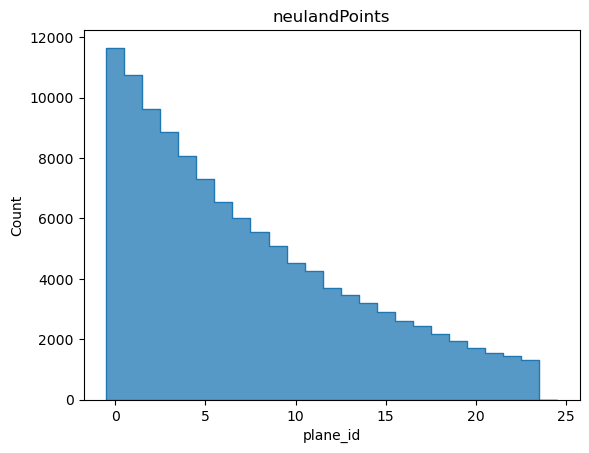

In [39]:
data_frame_points = pd.DataFrame({"plane_id": point_plane_ids, "times": point_times}).dropna()
graph = sns.histplot(data = data_frame_points, x = "plane_id", binwidth = 1, binrange = [-0.5, 24.5], element="step")
graph.set_title("neulandPoints")

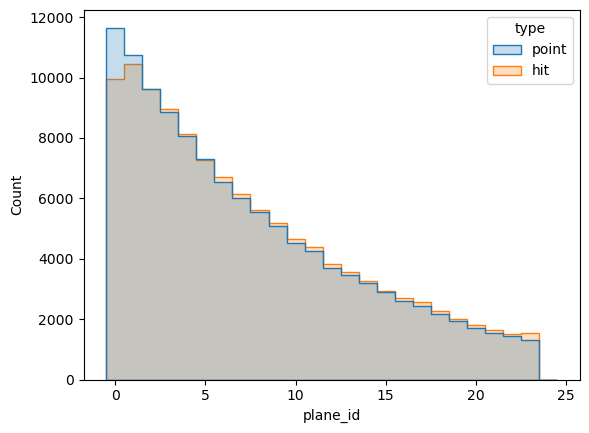

In [41]:
data_frame_points["type"] = "point"
data_frame_hits["type"] = "hit"
plane_id_compare = pd.concat([data_frame_points, data_frame_hits])
graph = sns.histplot(data = plane_id_compare, x = "plane_id", binwidth = 1, binrange = [-0.5, 24.5], element="step", hue = "type" )